# Learning Cost Function for Optimal Transport

From https://arxiv.org/pdf/2002.09650.pdf

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import ot
from typing import Callable
from rich.progress import track

from floOTflix.models import MFModel

# Generate Toy Dataset

To build a toy dataset, we create $r \in R^m$ and $c \in R^n$ two random marginal distribution and let $C_{truth} \in [0, 1]^{m,n}$ be a random cost matrix.

In [3]:
p = 1
m, n = 5, 5
k = 2

# create random marginal distributions
r = 1 + torch.rand(m)
c = 1 + torch.rand(n)

r /= torch.sum(r)
c /= torch.sum(c)

# create random cost matrix
U_truth = torch.rand(m, k)
V_truth = torch.rand(n, k)
A_truth = torch.rand(k, k)

C_truth = U_truth @ A_truth @ V_truth.t()

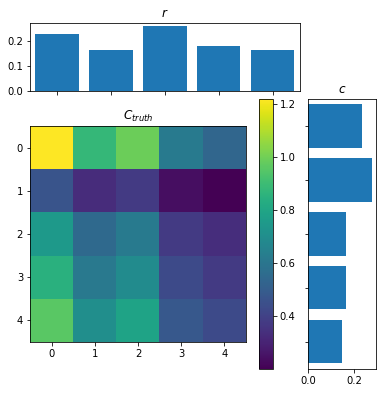

In [4]:
# from https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,
    width_ratios=(4, 1), height_ratios=(1, 4), left=0.1,
    right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)


sp = ax.imshow(C_truth)
fig.colorbar(sp, ax=ax)
ax.set_title('$C_{truth}$')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.bar(np.arange(m), r)
ax_histx.set_title('$r$')

ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.barh(np.arange(n), c)
ax_histy.set_title('$c$')

plt.show()


In [ ]:
import seaborn as sns

g = sns.jointplot(data=C_truth)
g.ax_marg_y.cla()
g.ax_marg_x.cla()
# sns.heatmap(data=df['Cost Dif.'].to_numpy().reshape(D, H).T, ax=g.ax_joint, cbar=False, cmap='Blues')

# g.ax_marg_y.barh(np.arange(0.5, H), df.groupby(['hour'])['Cost Dif.'].sum().to_numpy(), color='navy')
# g.ax_marg_x.bar(np.arange(0.5, D), df.groupby(['day'])['Cost Dif.'].sum().to_numpy(), color='navy')

# g.ax_joint.set_xticks(np.arange(0.5, D))
# g.ax_joint.set_xticklabels(range(1, D + 1), rotation=0)
# g.ax_joint.set_yticks(np.arange(0.5, H))
# g.ax_joint.set_yticklabels(range(H), rotation=0)

# # remove ticks between heatmao and histograms
# g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
# g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
# # remove ticks showing the heights of the histograms
# g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
# g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

# g.fig.set_size_inches(20, 8)  # jointplot creates its own figure, the size can only be changed afterwards
# # g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
# g.fig.subplots_adjust(hspace=0.05, wspace=0.02)  # less spaced needed when there are no tick labels
# plt.show()


/Users/lucasmrdt/.pyenv/versions/3.10.6/lib/python3.10/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


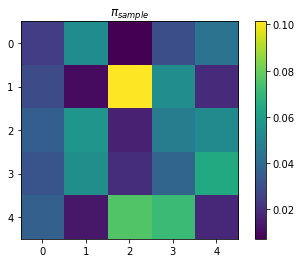

Min=0.007329804357141256, Max=0.10135013610124588, Sum=1.0


In [5]:
eps = 1e-1
pi_sample = ot.sinkhorn(r, c, C_truth, reg=eps)
# pi_sample /= pi_sample.sum()

sp = plt.imshow(pi_sample)
plt.title('$\pi_{sample}$')
plt.colorbar()
plt.show()

pi_min = pi_sample.min()
pi_max = pi_sample.max()

print(f"Min={pi_min}, Max={pi_max}, Sum={pi_sample.sum()}")

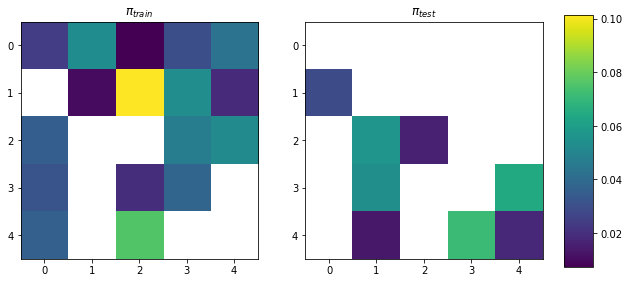

In [6]:
k = 5 # dim of latent space

N = m * n
N_train = int(.7 * N)

train_index = np.random.choice(N, N_train, replace=False)
test_index = np.setdiff1d(np.arange(N), train_index)

train_index = np.unravel_index(train_index, (m, n))
test_index = np.unravel_index(test_index, (m, n))

X_train = torch.from_numpy(np.array(train_index).T)
y_train = pi_sample[train_index]
pi_train = pi_sample.clone()
pi_train[test_index] = np.nan

X_test = torch.from_numpy(np.array(test_index).T)
y_test = pi_sample[test_index]
pi_test = pi_sample.clone()
pi_test[train_index] = np.nan

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(pi_train, vmin=pi_min, vmax=pi_max)
ax1.set_title('$\pi_{train}$')
ax2.imshow(pi_test, vmin=pi_min, vmax=pi_max)
ax2.set_title('$\pi_{test}$')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(sp, cax=cbar_ax)
plt.show()

In [7]:
mf_model = MFModel(m, n, k)
mf_model.fit(X_train, y_train, X_test, y_test, n_epochs=1000)

U, V = mf_model.U, mf_model.V
print(f'U: {U.shape} V: {V.shape}')

score = mf_model.score(X_test, y_test)
print(f"MFModel score: {score}")

Output()

[16:50:56] Epoch 0, train error: 1.3093165159225464, test error: 1.235261082649231                        ]8;id=849465;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=607420;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

           Epoch 100, train error: 0.6745900511741638, test error: 0.7221803665161133                     ]8;id=424575;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=273345;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

           Epoch 200, train error: 0.31934088468551636, test error: 0.41698870062828064                   ]8;id=729897;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=198581;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

           Epoch 300, train error: 0.12507590651512146, test error: 0.2342829555273056                    ]8;id=232093;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=963565;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

           Epoch 400, train error: 0.045891329646110535, test error: 0.13439112901687622                  ]8;id=415390;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=780744;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

           Epoch 500, train error: 0.02200292982161045, test error: 0.09121523797512054                   ]8;id=51054;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=788723;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

           Epoch 600, train error: 0.009284676983952522, test error: 0.071234330534935                    ]8;id=439051;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=447194;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

           Epoch 700, train error: 0.0025240762624889612, test error: 0.0625406876206398                  ]8;id=308315;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=373026;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

[16:50:57] Epoch 800, train error: 0.0002091692731482908, test error: 0.056431837379932404                ]8;id=342421;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=670681;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

           Epoch 900, train error: 0.00016781091107986867, test error: 0.04915926232933998                ]8;id=236784;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=452583;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

U: torch.Size([5, 5]) V: torch.Size([5, 5])
MFModel score: 0.043214596807956696


Min=0.03441593796014786, Max=0.12073466181755066


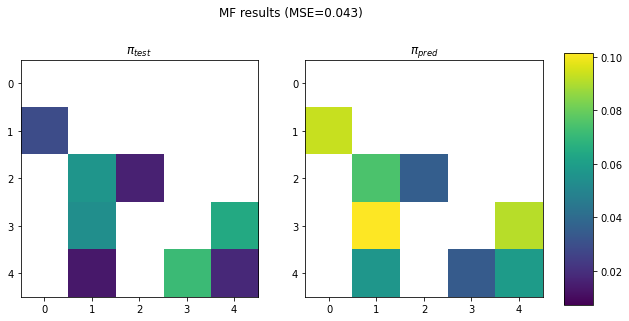

In [8]:
y_pred = mf_model.predict(X_test).detach()

pi_pred = torch.zeros(m, n) * np.nan
pi_pred[X_test[:,0], X_test[:,1]] = y_pred

print(f"Min={y_pred.min()}, Max={y_pred.max()}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(pi_test, vmin=pi_min, vmax=pi_max)
ax1.set_title('$\pi_{test}$')
ax2.imshow(pi_pred, vmin=pi_min, vmax=pi_max)
ax2.set_title('$\pi_{pred}$')
fig.suptitle(f'MF results (MSE={score:.3f})')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(sp, cax=cbar_ax)
plt.show()

# CLIDIOT (Cost Learning in Discrete Inverse OT) Algorithm


In [21]:

def CLIDIOT(pi_sample, prox_fn: Callable[[torch.TensorType], torch.TensorType], c_init, alpha_init, beta_init, eps=1e-1, max_iter=100, num_eps=1e-6):
    m, n = pi_sample.shape
    mu, nu = pi_sample@torch.ones(m), pi_sample.t()@torch.ones(n)
    # c = torch.rand(m, n)
    c, alpha, beta = c_init, alpha_init, beta_init
    u, v = torch.exp(alpha / eps), torch.exp(beta / eps)
    # u, v = torch.rand((m,1)), torch.rand((n,1))
    # c = c0
    # print(c0)
    # print(u, v)
    for _ in range(max_iter):
    # for _ in track(range(max_iter), description='CLIDIOT'):
        K = torch.exp(-c / eps)
        u = mu / (K@v + num_eps)
        v = nu / (K.t()@u + num_eps)
        # K = pi_sample / (torch.outer(u, v.t()) + num_eps)
        K = pi_sample / (u@v.t() + num_eps)
        c = prox_fn(K + num_eps)
    return c

def CLIDIOT_symmetric(pi_sample, eps=1e-1, max_iter=100, delta=1e-2):
    def prox_fn(K):
        c_hat = -eps * torch.log(K)
        return (c_hat + c_hat.t())/2

    m, n = pi_sample.shape
    c0 = torch.ones((m,n)) - torch.eye(m)
    return CLIDIOT(pi_sample, prox_fn, c0, eps, max_iter, delta)

def CLIDIOT_affinity(pi_sample, U, V, eps=1e-1, max_iter=100, delta=1e-2):
    U_inv = torch.linalg.pinv(U)
    V_inv = torch.linalg.pinv(V)
    k = U.shape[1]
    assert k == V.shape[1]
    A_init = torch.rand(k, k)
    c_init = U @ A_init @ V.t()
    alpha_init = torch.rand(U.shape[0])
    beta_init = torch.rand(V.shape[0])

    def prox_fn(K):
        return U @ U_inv @ (-eps * torch.log(K)) @ V_inv.t() @ V.t()

    return CLIDIOT(pi_sample, prox_fn=prox_fn, c_init=c_init, alpha_init=alpha_init, beta_init=beta_init, eps=eps, max_iter=max_iter)

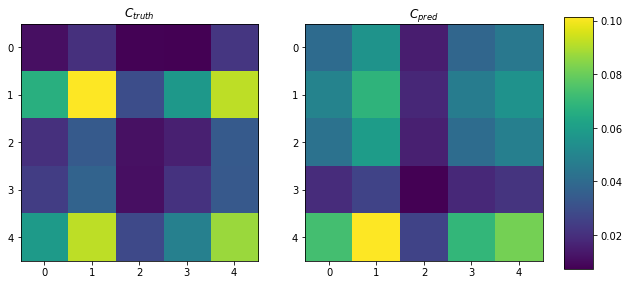

In [29]:
# C_pred = CLIDIOT_affinity(torch.nan_to_num(pi_train), U_truth, V_truth, max_iter=10000, eps=1e-2)
C_pred = CLIDIOT_affinity(pi_sample, U_truth, V_truth, max_iter=10000, eps=1e-2)
C_pred = C_pred.detach().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(C_truth)
ax1.set_title('$C_{truth}$')
ax2.imshow(C_pred)
ax2.set_title('$C_{pred}$')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(sp, cax=cbar_ax)
plt.show()

In [15]:
eps = 1e0
pi_pred = ot.sinkhorn(np.ones(m)/m, np.ones(n)/n, C_pred, reg=eps)
pi_pred = torch.from_numpy(pi_pred)
pi_pred_min, pi_pred_max = pi_pred[test_index].min(), pi_pred[test_index].max()
pi_pred[train_index] = np.nan

# rescale
pi_pred = pi_min + (pi_pred - pi_pred_min) / (pi_pred_max - pi_pred_min) * (pi_max - pi_min)

score = torch.sqrt((pi_pred[test_index] - pi_sample[test_index]).pow(2).mean())
print(f"CLIDIOT Score: {score}")

CLIDIOT Score: 0.024624632087759904


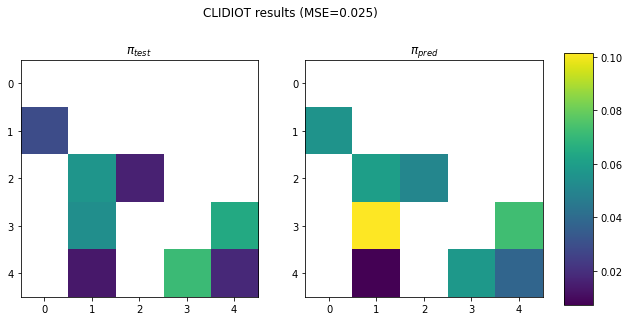

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(pi_test, vmin=pi_min, vmax=pi_max)
ax1.set_title('$\pi_{test}$')
ax2.imshow(pi_pred, vmin=pi_min, vmax=pi_max)
ax2.set_title('$\pi_{pred}$')
fig.suptitle(f'CLIDIOT results (MSE={score:.3f})')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(sp, cax=cbar_ax)
plt.show()

In [326]:
# def algo_paper(P, G, D, mu = None, nu = None, niter = 500, eps = 10, eps_num = 0.000001):
#   """
#   P is mxn; mu m dim; alpha m dim; vu n dim; beta n dim
#   """
#   m, n = P.shape
#   mu, nu = P @ np.ones((m, 1)), (P.T @ np.ones((n, 1)))

#   C = np.random.random((m, n))
#   alpha = mu
#   beta = nu
#   u = np.exp(alpha/eps)
#   v = np.exp(beta/eps)
#   G_pseudoinv_trans = np.linalg.pinv(G)
#   D_pseudoinv = np.linalg.pinv(D)
#   for it in range(niter):
#     K=np.exp(-1/eps*C)
#     u=mu/(np.dot(K,v) + eps_num)
#     v=nu/(np.dot(K.T,u) + eps_num)
#     K=P/(np.outer(u,v.T) + eps_num)
#     C=-eps*np.log(K+eps_num)
#     C = G @ G_pseudoinv_trans @ C @ D_pseudoinv.T @ D.T
#   return C

# C_pred = algo_paper(pi_sample.detach().numpy(), U.detach().numpy(), V.detach().numpy(), niter=10000)
# C_pred